In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utility_funcs import *
import xgboost as xgb

In [2]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

In [3]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df.drop(columns=['id_producto'], inplace=True)
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )

C:\Users\juanc\AppData\Local\Temp\ipykernel_30088\2870044259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df.drop(columns=['id_producto'], inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_30088\2870044259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [4]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)


# Eliminacion de 29 de febrero.
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)

C:\Users\juanc\AppData\Local\Temp\ipykernel_30088\1117770948.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_30088\1117770948.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [5]:
complete_demanda_prod_df.describe()

,date,demanda
count,1065,1065.000000
mean,2021-06-16 00:00:00,69.672300
min,2020-01-01 00:00:00,18.000000
25%,2020-09-23 00:00:00,53.000000
50%,2021-06-16 00:00:00,66.000000
75%,2022-03-09 00:00:00,83.000000
max,2022-11-30 00:00:00,183.000000
std,NaN,23.563876


In [8]:
# Generacion de variables exogenas
exog_vars_dict = generate_exogenous(complete_demanda_prod_df['date'].min(), complete_demanda_prod_df.shape[0])
exog_vars_df = pd.DataFrame(exog_vars_dict)
exog_vars_df['date'] = complete_demanda_prod_df['date']

In [9]:
# Unificacion de variables exogenas con dataframe inicial
full_data_df = complete_demanda_prod_df.merge(exog_vars_df ,how='left' ,left_on='date' ,right_on='date', suffixes=('_endog', '_exog'))

In [10]:
full_data_df.columns

Index(['date', 'demanda', 'es_fin_de_semana', 'is_feb_29', 'mes_sin',
       'mes_cos', 'dia_sin', 'dia_cos', 'dia_de_semana_sin',
       'dia_de_semana_cos', 'flg_despues_llegada_competencia'],
      dtype='object')

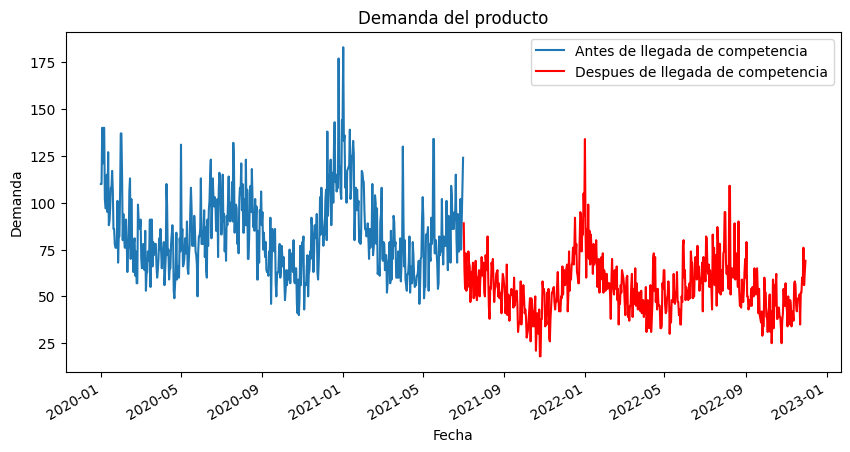

In [19]:
# Visualizacion de los datos
# Grafica de la variable objetivo:
plt.figure(figsize=(10,5))
# Filtro para registros antes de la llegada de la competencia
df_antes = full_data_df[full_data_df['flg_despues_llegada_competencia'] == False]
# Línea de demanda antes de la competencia
plt.plot(df_antes['date'], df_antes['demanda'], label='Antes de competencia')


# Filtro para registros despues de la llegada de la competencia
df_desp = full_data_df[full_data_df['flg_despues_llegada_competencia'] == True]
# Línea de demanda antes de la competencia
plt.plot(df_desp['date'], df_desp['demanda'], label='Despues de competencia', color='red')


# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotar los x-ticks para mayor legibilidad
plt.gcf().autofmt_xdate()

plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title("Demanda del producto")
plt.legend(['Antes de llegada de competencia', 'Despues de llegada de competencia'])

plt.show()

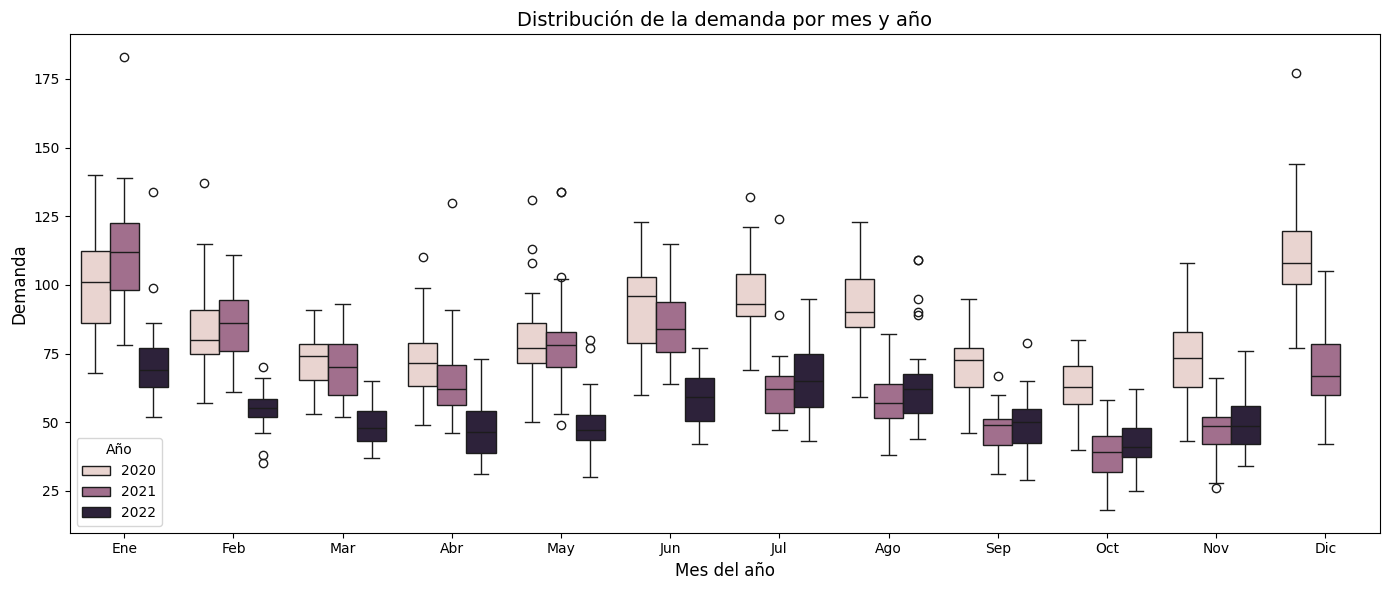

In [20]:
# Asegúrate de que 'date' sea datetime
full_data_df['date'] = pd.to_datetime(full_data_df['date'])

# Extraer mes y año como columnas separadas
full_data_df['mes'] = full_data_df['date'].dt.month
full_data_df['anio'] = full_data_df['date'].dt.year

# Ordenar los meses para que salgan del 1 al 12
meses_orden = list(range(1, 13))

plt.figure(figsize=(14, 6))

# Gráfico de boxplot
sns.boxplot(data=full_data_df, x='mes', y='demanda', hue='anio', order=meses_orden)

# Títulos y etiquetas
plt.title("Distribución de la demanda por mes y año", fontsize=14)
plt.xlabel("Mes del año", fontsize=12)
plt.ylabel("Demanda", fontsize=12)
plt.legend(title='Año')
plt.xticks(ticks=range(12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.tight_layout()
plt.show()


In [21]:
from statsmodels.tsa.seasonal import STL

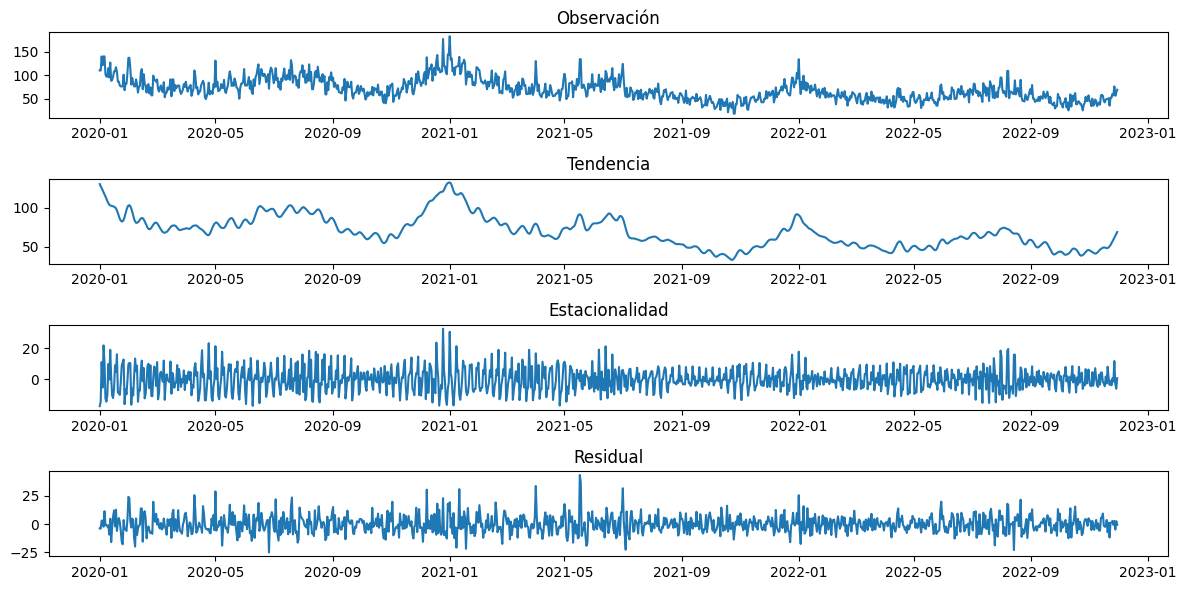

In [28]:
#decomposicion = seasonal_decompose(demanda_prod_df['demanda']
#                                   , model='additive'
#                                   , period=1365
#                                   )

stl = STL(full_data_df['demanda'], period=7)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(full_data_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(full_data_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(full_data_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(full_data_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()